<a href="https://www.kaggle.com/code/dataranch/abnb-ohlc-xgboost-fastai-eda?scriptVersionId=108478412" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**ABNB OHLC Data Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.

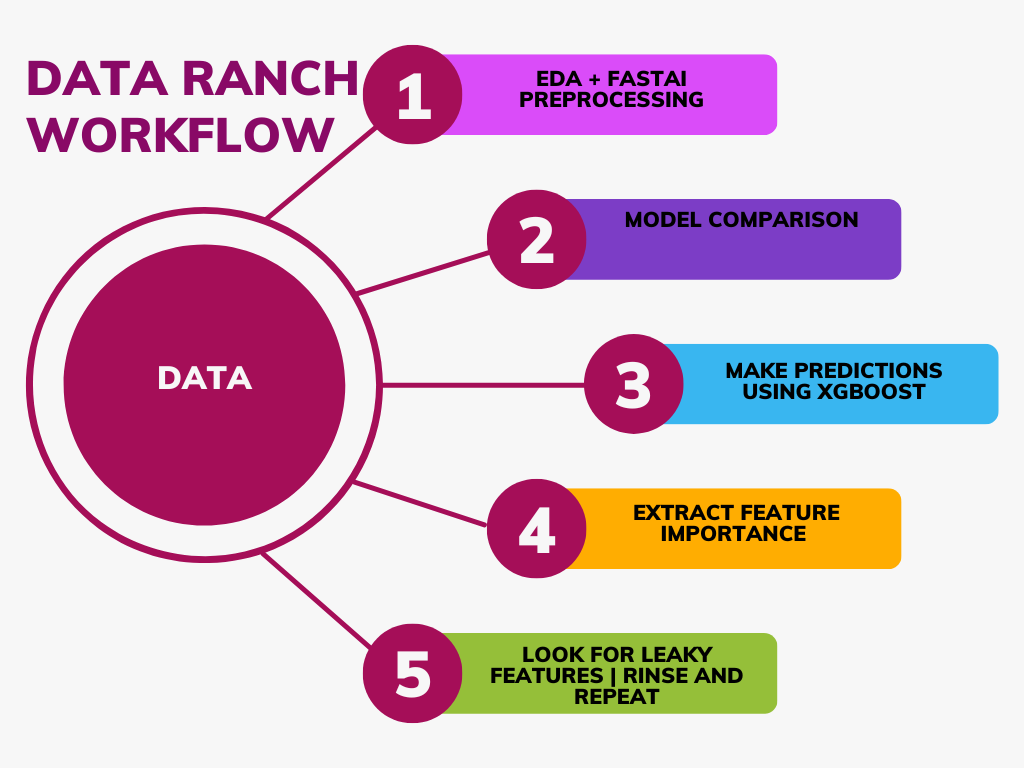

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.2 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
# For Styling
plt.style.use('seaborn-bright')

In [10]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'airbnb-inc-stock-market-analysis'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = False
SEP_COMMA = True
SHUFFLE_DATA = True

In [11]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/airbnb-inc-stock-market-analysis
CSV!


In [12]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-11,146.55,151.50,135.10,139.25,139.25,26980800
1,2020-12-14,135.00,135.30,125.16,130.00,130.00,16966100
2,2020-12-15,126.69,127.60,121.50,124.80,124.80,10914400
3,2020-12-16,125.83,142.00,124.91,137.99,137.99,20409600
4,2020-12-17,143.00,152.45,142.67,147.05,147.05,15054700
...,...,...,...,...,...,...,...
449,2022-09-26,101.78,105.36,101.56,103.23,103.23,5278800
450,2022-09-27,106.04,108.17,104.14,106.37,106.37,5081000
451,2022-09-28,106.70,111.13,105.78,110.69,110.69,4518200
452,2022-09-29,109.19,109.47,105.17,106.66,106.66,4259500


In [13]:
if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')


if SEP_COMMA:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str.replace('%', '').str.replace(',', '')
            #Try to convert this new column to a numeric type
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors='coerce').dropna()
            except Exception:
                print(f'{col} can not be converted to a float!')

In [14]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-11,146.55,151.50,135.10,139.25,139.25,26980800
1,2020-12-14,135.00,135.30,125.16,130.00,130.00,16966100
2,2020-12-15,126.69,127.60,121.50,124.80,124.80,10914400
3,2020-12-16,125.83,142.00,124.91,137.99,137.99,20409600
4,2020-12-17,143.00,152.45,142.67,147.05,147.05,15054700
...,...,...,...,...,...,...,...
449,2022-09-26,101.78,105.36,101.56,103.23,103.23,5278800
450,2022-09-27,106.04,108.17,104.14,106.37,106.37,5081000
451,2022-09-28,106.70,111.13,105.78,110.69,110.69,4518200
452,2022-09-29,109.19,109.47,105.17,106.66,106.66,4259500


In [15]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [16]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

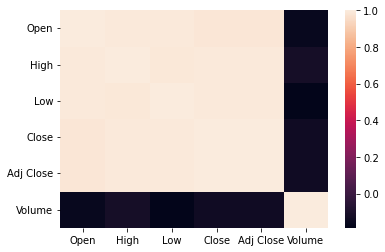

In [17]:
sns.heatmap(df.corr())

In [18]:
df.head().style.background_gradient(cmap = "inferno")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-11,146.55,151.50,135.10,139.25,139.25,26980800
1,2020-12-14,135.00,135.30,125.16,130.00,130.00,16966100
2,2020-12-15,126.69,127.60,121.50,124.80,124.80,10914400
3,2020-12-16,125.83,142.00,124.91,137.99,137.99,20409600
4,2020-12-17,143.00,152.45,142.67,147.05,147.05,15054700


In [19]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Open,454.00,152.74,28.34,88.88,136.82,154.93,172.56,216.24
High,454.00,156.47,29.11,91.46,139.84,159.10,175.97,219.94
Low,454.00,148.97,27.49,86.71,132.92,151.23,168.60,209.09
Close,454.00,152.73,28.23,89.08,135.96,155.65,171.74,216.84
Adj Close,454.00,152.73,28.23,89.08,135.96,155.65,171.74,216.84
Volume,454.00,6690328.19,4417386.73,1995400.00,4114375.00,5450000.00,7631375.00,39755000.00


In [20]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [21]:
#Remove feature we don't want to make a prediction on
del(df['Date'])

Target Variable: Volume
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Adj Close']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Adj Close']
Categorical variables that made the cut : []
Tabular Object size: 454


  5%|▍         | 2/42 [00:00<00:02, 15.40it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': -0.524236369587262, 'Adjusted R-Squared': -0.6149647249198371, 'RMSE': 5270883.781681342, 'Time taken': 0.09506368637084961}
{'Model': 'BaggingRegressor', 'R-Squared': 0.055933824673697785, 'Adjusted R-Squared': -0.0002605905242965001, 'RMSE': 4148188.6544268397, 'Time taken': 0.03440594673156738}
{'Model': 'BayesianRidge', 'R-Squared': -0.0003420363859016895, 'Adjusted R-Squared': -0.05988620521839594, 'RMSE': 4270036.034757174, 'Time taken': 0.02726006507873535}
{'Model': 'DecisionTreeRegressor', 'R-Squared': -0.5679304570690777, 'Adjusted R-Squared': -0.661259650942237, 'RMSE': 5345898.129635884, 'Time taken': 0.010773897171020508}
{'Model': 'DummyRegressor', 'R-Squared': -0.0003420363929018677, 'Adjusted R-Squared': -0.05988620522581267, 'RMSE': 4270036.034772114, 'Time taken': 0.008628606796264648}
{'Model': 'ElasticNet', 'R-Squared': 0.06549846788763125, 'Adjusted R-Squared': 0.009873376690466396, 'RMSE': 4127121.831833471, 'Time taken'

 21%|██▏       | 9/42 [00:00<00:01, 25.67it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.056017778704799515, 'Adjusted R-Squared': -0.00017163922943863597, 'RMSE': 4148004.2050147015, 'Time taken': 0.155595064163208}
{'Model': 'GammaRegressor', 'R-Squared': 0.05764128997480222, 'Adjusted R-Squared': 0.001548509616159488, 'RMSE': 4144435.6899348223, 'Time taken': 0.012912511825561523}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -686.9077236405489, 'Adjusted R-Squared': -727.8546119524863, 'RMSE': 111975335.74339584, 'Time taken': 0.05110645294189453}


 29%|██▊       | 12/42 [00:00<00:01, 20.18it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': -0.017392526877859193, 'Adjusted R-Squared': -0.07795160585868421, 'RMSE': 4306272.933248791, 'Time taken': 0.14553260803222656}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.13842689000367936, 'Adjusted R-Squared': 0.08714277631342215, 'RMSE': 3962810.8964643856, 'Time taken': 0.18988776206970215}


 45%|████▌     | 19/42 [00:00<00:01, 22.26it/s]

{'Model': 'HuberRegressor', 'R-Squared': -0.01104775519474499, 'Adjusted R-Squared': -0.07122916919443223, 'RMSE': 4292824.313970549, 'Time taken': 0.018569469451904297}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.01512583184748828, 'Adjusted R-Squared': -0.0434976305425423, 'RMSE': 4236894.53662782, 'Time taken': 0.010338544845581055}
{'Model': 'KernelRidge', 'R-Squared': -2.1841545277119607, 'Adjusted R-Squared': -2.3736875353138633, 'RMSE': 7618234.706105031, 'Time taken': 0.02333855628967285}
{'Model': 'Lars', 'R-Squared': 0.21591137046829212, 'Adjusted R-Squared': 0.16923942823426186, 'RMSE': 3780418.31454157, 'Time taken': 0.02740311622619629}
{'Model': 'LarsCV', 'R-Squared': 0.21591137046829212, 'Adjusted R-Squared': 0.16923942823426186, 'RMSE': 3780418.31454157, 'Time taken': 0.03674721717834473}
{'Model': 'Lasso', 'R-Squared': 0.11960980399241239, 'Adjusted R-Squared': 0.06720562565862742, 'RMSE': 4005851.8105729516, 'Time taken': 0.021144628524780273}
LassoCV model failed

 60%|█████▉    | 25/42 [00:01<00:00, 30.64it/s]

{'Model': 'LinearRegression', 'R-Squared': 0.12177043641272245, 'Adjusted R-Squared': 0.06949486715157493, 'RMSE': 4000933.258442384, 'Time taken': 0.011213302612304688}
{'Model': 'LinearSVR', 'R-Squared': -2.5021513754692575, 'Adjusted R-Squared': -2.710612766866237, 'RMSE': 7989594.491496995, 'Time taken': 0.010750055313110352}


 69%|██████▉   | 29/42 [00:01<00:01, 12.82it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.502375949112105, 'Adjusted R-Squared': -2.710850707987826, 'RMSE': 7989850.651694616, 'Time taken': 0.650303840637207}
{'Model': 'NuSVR', 'R-Squared': -0.05087683553802602, 'Adjusted R-Squared': -0.11342902812957512, 'RMSE': 4376563.055706112, 'Time taken': 0.03801584243774414}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.08293171041586689, 'Adjusted R-Squared': 0.028344312226335155, 'RMSE': 4088444.614530923, 'Time taken': 0.020131349563598633}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1217556240921499, 'Adjusted R-Squared': 0.06947917314525409, 'RMSE': 4000966.998399787, 'Time taken': 0.030913591384887695}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -2.2399447865028352, 'Adjusted R-Squared': -2.4327986428422896, 'RMSE': 7684685.263760195, 'Time taken': 0.04433441162109375}
{'Model': 'PoissonRegressor', 'R-Squared': 0.07692511188819862, 'Adjusted R-Squared': 0.021980178072019907, 'RMSE': 4101811.974966128, 'Time

 76%|███████▌  | 32/42 [00:05<00:03,  2.61it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.10063200062401578, 'Adjusted R-Squared': -0.1661458101849691, 'RMSE': 4478972.008574548, 'Time taken': 3.9545021057128906}
{'Model': 'RANSACRegressor', 'R-Squared': 0.1957704463808162, 'Adjusted R-Squared': 0.14789963961776953, 'RMSE': 3828664.352162803, 'Time taken': 0.14095401763916016}


 81%|████████  | 34/42 [00:06<00:02,  2.90it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.06173440594579527, 'Adjusted R-Squared': 0.005885263442568789, 'RMSE': 4135425.2588910935, 'Time taken': 0.22090697288513184}
{'Model': 'Ridge', 'R-Squared': 0.2063998745507809, 'Adjusted R-Squared': 0.1591617718454702, 'RMSE': 3803278.6403943095, 'Time taken': 0.010956287384033203}
{'Model': 'RidgeCV', 'R-Squared': 0.14125449510949029, 'Adjusted R-Squared': 0.09013869124695995, 'RMSE': 3956302.7586303563, 'Time taken': 0.009554862976074219}
{'Model': 'SGDRegressor', 'R-Squared': 0.22289371454564255, 'Adjusted R-Squared': 0.17663738803050222, 'RMSE': 3763548.2769329124, 'Time taken': 0.01873779296875}
{'Model': 'SVR', 'R-Squared': -0.10253049079679899, 'Adjusted R-Squared': -0.16815730572517995, 'RMSE': 4482833.254044671, 'Time taken': 0.01958155632019043}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.12177043641272245, 'Adjusted R-Squared': 0.06949486715157493, 'RMSE': 4000933.258442384, 'Time taken': 0.009871959686279297}
{'M

100%|██████████| 42/42 [00:06<00:00,  6.20it/s]

{'Model': 'XGBRegressor', 'R-Squared': -0.17174648916144375, 'Adjusted R-Squared': -0.24149330399248203, 'RMSE': 4621405.862730123, 'Time taken': 0.4485349655151367}
{'Model': 'LGBMRegressor', 'R-Squared': 0.14956598562226164, 'Adjusted R-Squared': 0.09894491333787248, 'RMSE': 3937110.387205311, 'Time taken': 0.1022951602935791}
Project: airbnb-inc-stock-market-analysis
airbnb-inc-stock-market-analysis
Target: Volume
Volume
Target Standard Deviation: 4447078.908808992
                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
SGDRegressor                                 0.18       0.22   3763548.28   
LassoLarsIC                                  0.17       0.22   3780418.31   
Lars                                         0.17       0.22   3780418.31   
LassoLarsCV                                  0.17       0.22   3780418.31   
LarsCV                                       0.17       0.22   37

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,60539136901120.000000,63837776642048.000000,7989854.500000,00:00
1,61816084365312.000000,63836635791360.000000,7989783.000000,00:00
2,63779316432896.000000,63834026934272.000000,7989620.000000,00:00
3,64065384742912.000000,63817253912576.000000,7988570.000000,00:00
4,65070461616128.000000,63769313017856.000000,7985569.000000,00:00
5,65140821065728.000000,63672017747968.000000,7979474.500000,00:00
6,65640262008832.000000,63553193115648.000000,7972025.500000,00:00
7,65456434053120.000000,62972693053440.000000,7935533.500000,00:00
8,65636080287744.000000,63362079653888.000000,7960029.500000,00:00


Better model found at epoch 0 with _rmse value: 7989854.5.
Better model found at epoch 1 with _rmse value: 7989783.0.
Better model found at epoch 2 with _rmse value: 7989620.0.
Better model found at epoch 3 with _rmse value: 7988570.0.
Better model found at epoch 4 with _rmse value: 7985569.0.
Better model found at epoch 5 with _rmse value: 7979474.5.
Better model found at epoch 6 with _rmse value: 7972025.5.
Better model found at epoch 7 with _rmse value: 7935533.5.
No improvement since epoch 7: early stopping


,Open,High,Low,Close,Adj Close,Volume,Volume_pred
0,0.76,0.82,0.48,0.37,0.37,7645700.00,30172.04
1,1.34,1.34,1.49,1.43,1.43,6704100.00,24886.35
2,-2.14,-1.96,-2.06,-1.94,-1.94,11293100.00,124285.89
3,-0.12,-0.24,-0.13,-0.25,-0.25,7479000.00,53392.78
4,-1.35,-1.32,-1.27,-1.30,-1.30,6495000.00,103008.56
5,-1.79,-1.79,-1.93,-2.01,-2.01,7744100.00,118473.29
6,1.09,1.04,1.04,0.95,0.95,4413600.00,22753.41
7,0.68,0.60,0.81,0.73,0.73,2827100.00,20186.44
8,-2.00,-1.84,-1.96,-1.79,-1.79,28797400.00,121973.59


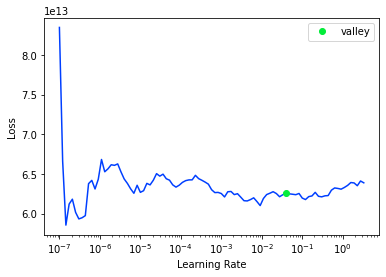

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
     actual  predicted
0  11293100 5381510.50
1   2725200 2665927.25
2   4413600 3985660.25
3   2869700 4202215.00
4   8334600 6237675.00
XGBoost RMSE:  4621405.862730123


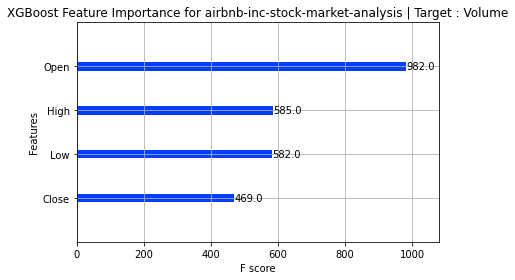

Target Variable: Adj Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 454


 17%|█▋        | 7/42 [00:00<00:01, 31.99it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.997688014848319, 'Adjusted R-Squared': 0.9975503966845285, 'RMSE': 1.4332147827478505, 'Time taken': 0.10221219062805176}
{'Model': 'BaggingRegressor', 'R-Squared': 0.999560791608373, 'Adjusted R-Squared': 0.9995346482517286, 'RMSE': 0.6246749250166687, 'Time taken': 0.034558773040771484}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.204724695119642e-11, 'Time taken': 0.010360240936279297}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9992925202383687, 'Adjusted R-Squared': 0.9992504083477953, 'RMSE': 0.7928221392033316, 'Time taken': 0.010826349258422852}
{'Model': 'DummyRegressor', 'R-Squared': -0.00893749646817077, 'Adjusted R-Squared': -0.06899329982937141, 'RMSE': 29.939938, 'Time taken': 0.008830785751342773}
{'Model': 'ElasticNet', 'R-Squared': 0.9751547146242159, 'Adjusted R-Squared': 0.9736758285899431, 'RMSE': 4.698300099161009, 'Time taken': 0.009630203247070312}
{'Model': 'ElasticNetCV', '

 24%|██▍       | 10/42 [00:00<00:01, 23.98it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.999589028966159, 'Adjusted R-Squared': 0.9995645664046208, 'RMSE': 0.6042607218614752, 'Time taken': 0.14907026290893555}
{'Model': 'GammaRegressor', 'R-Squared': 0.9472533642998651, 'Adjusted R-Squared': 0.9441136836034285, 'RMSE': 6.845672855288465, 'Time taken': 0.012195110321044922}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.706898730243362, 'Adjusted R-Squared': 0.6894522260911812, 'RMSE': 16.137178712169952, 'Time taken': 0.038518667221069336}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9998541883232559, 'Adjusted R-Squared': 0.999845509056783, 'RMSE': 0.35992740128841405, 'Time taken': 0.1531364917755127}


 38%|███▊      | 16/42 [00:00<00:01, 16.10it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9967532682559896, 'Adjusted R-Squared': 0.9965600104140843, 'RMSE': 1.6984077477972577, 'Time taken': 0.22507834434509277}
{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.9548144912916677e-10, 'Time taken': 0.05523204803466797}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9827186592129091, 'Adjusted R-Squared': 0.9816900079755823, 'RMSE': 3.9183886, 'Time taken': 0.010483741760253906}
{'Model': 'KernelRidge', 'R-Squared': -25.457596589431933, 'Adjusted R-Squared': -27.03245352927907, 'RMSE': 153.31828542968483, 'Time taken': 0.03366732597351074}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 6.260791457536674e-13, 'Time taken': 0.03991127014160156}


 55%|█████▍    | 23/42 [00:01<00:00, 22.69it/s]

{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 6.260791457536674e-13, 'Time taken': 0.06666016578674316}
{'Model': 'Lasso', 'R-Squared': 0.9986902094273304, 'Adjusted R-Squared': 0.9986122457027667, 'RMSE': 1.0787472182872422, 'Time taken': 0.015622138977050781}
{'Model': 'LassoCV', 'R-Squared': 0.9999986192312975, 'Adjusted R-Squared': 0.9999985370426843, 'RMSE': 0.03502508726014642, 'Time taken': 0.06377911567687988}
{'Model': 'LassoLars', 'R-Squared': 0.5232362315482857, 'Adjusted R-Squared': 0.49485743580711217, 'RMSE': 20.581185198873698, 'Time taken': 0.010488510131835938}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 6.260791457536674e-13, 'Time taken': 0.015743017196655273}
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 6.260791457536674e-13, 'Time taken': 0.010798215866088867}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.869670127525781e-14, 'Time ta

 71%|███████▏  | 30/42 [00:01<00:00, 13.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': -11.9827242484817, 'Adjusted R-Squared': -12.755505453748468, 'RMSE': 107.39935548642674, 'Time taken': 0.6787593364715576}
{'Model': 'NuSVR', 'R-Squared': 0.904611914273358, 'Adjusted R-Squared': 0.8989340520277245, 'RMSE': 9.20589093531086, 'Time taken': 0.03868246078491211}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.4676907639293466e-14, 'Time taken': 0.021633386611938477}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.4676907639293466e-14, 'Time taken': 0.0281217098236084}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999985100637688, 'Adjusted R-Squared': 0.9999984213770884, 'RMSE': 0.03638334288031746, 'Time taken': 0.020784378051757812}
{'Model': 'PoissonRegressor', 'R-Squared': 0.987900427052685, 'Adjusted R-Squared': 0.9871802143772496, 'RMSE': 3.278715847513587, 'Time taken': 0.014026641845703125}


 79%|███████▊  | 33/42 [00:05<00:03,  2.52it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.0325866581583103, 'Adjusted R-Squared': -0.09405014971535253, 'RMSE': 30.288796222813694, 'Time taken': 3.6926252841949463}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.095372231637259e-14, 'Time taken': 0.022834062576293945}


 83%|████████▎ | 35/42 [00:06<00:02,  2.88it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.999621998682881, 'Adjusted R-Squared': 0.999599498604481, 'RMSE': 0.5795159789973077, 'Time taken': 0.2935161590576172}
{'Model': 'Ridge', 'R-Squared': 0.9996685580751908, 'Adjusted R-Squared': 0.9996488293891903, 'RMSE': 0.5426533393855145, 'Time taken': 0.009836673736572266}
{'Model': 'RidgeCV', 'R-Squared': 0.9999924104450799, 'Adjusted R-Squared': 0.9999919586858584, 'RMSE': 0.08211583487055311, 'Time taken': 0.011244773864746094}
{'Model': 'SGDRegressor', 'R-Squared': 0.9992956637154609, 'Adjusted R-Squared': 0.9992537389366193, 'RMSE': 0.7910588429975192, 'Time taken': 0.02152228355407715}
{'Model': 'SVR', 'R-Squared': 0.9092525521831339, 'Adjusted R-Squared': 0.9038509183845109, 'RMSE': 8.97916533964206, 'Time taken': 0.018409252166748047}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.869670127525781e-14, 'Time taken': 0.009911775588989258}
{'Model': 'TweedieRegressor', 'R-Squared'

100%|██████████| 42/42 [00:06<00:00,  6.38it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.999087242086316, 'Adjusted R-Squared': 0.9990329112581205, 'RMSE': 0.90052664, 'Time taken': 0.42236876487731934}
{'Model': 'LGBMRegressor', 'R-Squared': 0.996878750618754, 'Adjusted R-Squared': 0.9966929619651084, 'RMSE': 1.6652636160090248, 'Time taken': 0.06532645225524902}
Project: airbnb-inc-stock-market-analysis
airbnb-inc-stock-market-analysis
Target: Adj Close
Adj Close
Target Standard Deviation: 27.754358291625977
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsCV                                  1.00       1.00   0.00   
BayesianRidge                                1.00       1.00   0.00   
LinearRegression                             1.00       1.00   0.00   
LassoLarsIC                                  1.00       1.00   0.00   
TransformedTargetRegressor                   1.00       1.00   0.00   
OrthogonalMatchingPursuitCV        

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,23417.261719,14217.901367,119.238838,00:00
1,21357.271484,8043.338867,89.684662,00:00
2,18006.658203,24917.158203,157.851700,00:00


Better model found at epoch 0 with _rmse value: 119.23883819580078.
Better model found at epoch 1 with _rmse value: 89.68466186523438.
No improvement since epoch 1: early stopping


,Open,High,Low,Close,Volume,Adj Close,Adj Close_pred
0,1.43,1.37,1.42,1.48,-0.53,194.39,263.52
1,-0.16,-0.19,-0.11,-0.08,0.53,151.15,15.12
2,-0.10,-0.08,-0.00,-0.03,1.22,152.52,30.44
3,-1.70,-1.71,-1.68,-1.65,-0.31,107.36,89.27
4,1.21,1.10,1.08,0.98,0.96,180.40,196.01
5,0.78,0.70,0.85,0.86,-0.76,177.02,129.00
6,-0.51,-0.52,-0.46,-0.41,-0.03,142.00,16.81
7,0.79,0.66,0.80,0.78,-0.99,174.88,114.98
8,0.85,0.74,0.91,0.79,-0.91,175.35,135.92


<Figure size 432x288 with 0 Axes>

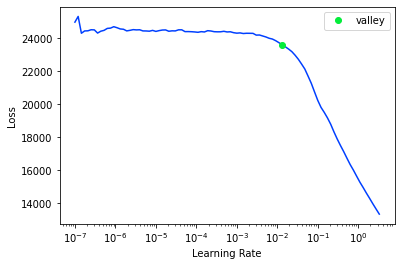

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  123.48     123.87
1  113.54     114.32
2  142.00     142.02
3  114.17     114.71
4  171.31     171.10
XGBoost RMSE:  0.90052664


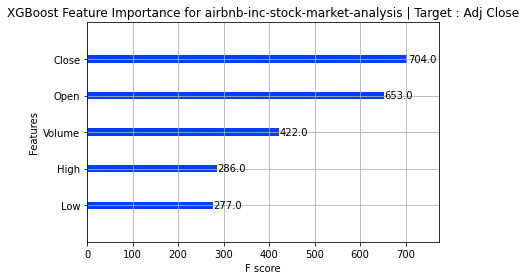

Target Variable: Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 454


 17%|█▋        | 7/42 [00:00<00:01, 31.68it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9978364948751325, 'Adjusted R-Squared': 0.9977077148081761, 'RMSE': 1.2024645993074536, 'Time taken': 0.10190701484680176}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9995730900159914, 'Adjusted R-Squared': 0.9995476787074195, 'RMSE': 0.534147858087298, 'Time taken': 0.033789873123168945}
{'Model': 'BayesianRidge', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 4.982213309029929e-11, 'Time taken': 0.010633707046508789}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9995651221088796, 'Adjusted R-Squared': 0.9995392365201224, 'RMSE': 0.539109518663773, 'Time taken': 0.011296510696411133}
{'Model': 'DummyRegressor', 'R-Squared': -0.05474105730472578, 'Adjusted R-Squared': -0.11752326309667382, 'RMSE': 26.550106, 'Time taken': 0.009146928787231445}
{'Model': 'ElasticNet', 'R-Squared': 0.970051872092151, 'Adjusted R-Squared': 0.9682692454309696, 'RMSE': 4.473816584063286, 'Time taken': 0.009886980056762695}
{'Model': 'ElasticNetCV', 'R

 24%|██▍       | 10/42 [00:00<00:01, 23.57it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9990389623727757, 'Adjusted R-Squared': 0.9989817577521075, 'RMSE': 0.8014261910591416, 'Time taken': 0.1523761749267578}
{'Model': 'GammaRegressor', 'R-Squared': 0.94208407475103, 'Adjusted R-Squared': 0.938636698248115, 'RMSE': 6.2214603098922785, 'Time taken': 0.012416601181030273}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9755141050056718, 'Adjusted R-Squared': 0.9740566112560094, 'RMSE': 4.045305517034481, 'Time taken': 0.05681157112121582}


 31%|███       | 13/42 [00:00<00:02, 12.83it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9995711944426042, 'Adjusted R-Squared': 0.999545670302283, 'RMSE': 0.5353324110872281, 'Time taken': 0.16928935050964355}
{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9979868492648634, 'Adjusted R-Squared': 0.9978670188639623, 'RMSE': 1.1599292025077688, 'Time taken': 0.19724297523498535}


 45%|████▌     | 19/42 [00:01<00:01, 17.85it/s]

{'Model': 'HuberRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 8.433388484826791e-10, 'Time taken': 0.057367563247680664}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9855661187397635, 'Adjusted R-Squared': 0.9847069591409399, 'RMSE': 3.1058817, 'Time taken': 0.010795831680297852}
{'Model': 'KernelRidge', 'R-Squared': -33.339594233537326, 'Adjusted R-Squared': -35.38361769981931, 'RMSE': 151.49242409174414, 'Time taken': 0.03539609909057617}
{'Model': 'Lars', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.438778892526582e-14, 'Time taken': 0.03769111633300781}
{'Model': 'LarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.438778892526582e-14, 'Time taken': 0.061425209045410156}
{'Model': 'Lasso', 'R-Squared': 0.9987122469106876, 'Adjusted R-Squared': 0.9986355949410857, 'RMSE': 0.9277044410400281, 'Time taken': 0.01835465431213379}


 55%|█████▍    | 23/42 [00:01<00:00, 22.13it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9999974962817907, 'Adjusted R-Squared': 0.9999973472509449, 'RMSE': 0.0409059100828984, 'Time taken': 0.0723114013671875}
{'Model': 'LassoLars', 'R-Squared': 0.5312578754902986, 'Adjusted R-Squared': 0.5033565585551973, 'RMSE': 17.699472672733638, 'Time taken': 0.010414361953735352}
{'Model': 'LassoLarsCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.438778892526582e-14, 'Time taken': 0.015369415283203125}
{'Model': 'LassoLarsIC', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 3.438778892526582e-14, 'Time taken': 0.011137723922729492}
{'Model': 'LinearRegression', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.6477511745853316e-14, 'Time taken': 0.010904788970947266}
{'Model': 'LinearSVR', 'R-Squared': 0.999457724093001, 'Adjusted R-Squared': 0.9994254457652035, 'RMSE': 0.6020097015960972, 'Time taken': 0.012615203857421875}


 71%|███████▏  | 30/42 [00:02<00:00, 12.14it/s]

{'Model': 'MLPRegressor', 'R-Squared': -18.749059633000243, 'Adjusted R-Squared': -19.924598896869306, 'RMSE': 114.88585111661209, 'Time taken': 0.7943553924560547}
{'Model': 'NuSVR', 'R-Squared': 0.9229885213615319, 'Adjusted R-Squared': 0.9184045047759087, 'RMSE': 7.174160135950768, 'Time taken': 0.03771233558654785}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 5.99182245303757e-15, 'Time taken': 0.020430326461791992}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 5.99182245303757e-15, 'Time taken': 0.028809070587158203}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999961579836492, 'Adjusted R-Squared': 0.9999959292921997, 'RMSE': 0.05067257099358195, 'Time taken': 0.025798320770263672}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9880546343165256, 'Adjusted R-Squared': 0.9873436006448902, 'RMSE': 2.82548535157651, 'Time taken': 0.01911330223083496}


 79%|███████▊  | 33/42 [00:07<00:05,  1.78it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.034574714145293006, 'Adjusted R-Squared': -0.09615654236822713, 'RMSE': 26.295066002343738, 'Time taken': 5.376979351043701}
{'Model': 'RANSACRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 2.0263967936488748e-14, 'Time taken': 0.04718327522277832}


 83%|████████▎ | 35/42 [00:07<00:03,  2.12it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9993664640436069, 'Adjusted R-Squared': 0.999328753570012, 'RMSE': 0.6506972474209719, 'Time taken': 0.24928045272827148}
{'Model': 'Ridge', 'R-Squared': 0.9991655532744875, 'Adjusted R-Squared': 0.9991158838265404, 'RMSE': 0.7467799389342462, 'Time taken': 0.011279821395874023}
{'Model': 'RidgeCV', 'R-Squared': 0.9999742733647955, 'Adjusted R-Squared': 0.9999727420174619, 'RMSE': 0.1311247972299391, 'Time taken': 0.011054515838623047}
{'Model': 'SGDRegressor', 'R-Squared': 0.9982951815690657, 'Adjusted R-Squared': 0.9981937042815101, 'RMSE': 1.0674127876787476, 'Time taken': 0.022500991821289062}
{'Model': 'SVR', 'R-Squared': 0.927183985982403, 'Adjusted R-Squared': 0.9228496994337365, 'RMSE': 6.976005049721064, 'Time taken': 0.018813371658325195}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 1.0, 'Adjusted R-Squared': 1.0, 'RMSE': 1.6477511745853316e-14, 'Time taken': 0.01082301139831543}
{'Model': 'TweedieRegressor', 'R-Square

100%|██████████| 42/42 [00:08<00:00,  5.00it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9986528465710328, 'Adjusted R-Squared': 0.9985726588669276, 'RMSE': 0.94885945, 'Time taken': 0.42657947540283203}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9968239487825772, 'Adjusted R-Squared': 0.9966348981148735, 'RMSE': 1.4569246257986619, 'Time taken': 0.06435418128967285}
Project: airbnb-inc-stock-market-analysis
airbnb-inc-stock-market-analysis
Target: Close
Close
Target Standard Deviation: 28.619142532348633
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsCV                                  1.00       1.00   0.00   
LarsCV                                       1.00       1.00   0.00   
RANSACRegressor                              1.00       1.00   0.00   
HuberRegressor                               1.00       1.00   0.00   
OrthogonalMatchingPursuit                    1.00       1.00   0.00   
OrthogonalMatchingPursuitCV              

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,22517.611328,15451.755859,124.305084,00:00
1,21028.623047,9439.997070,97.159653,00:00
2,17860.431641,12678.933594,112.600769,00:00


Better model found at epoch 0 with _rmse value: 124.30508422851562.
Better model found at epoch 1 with _rmse value: 97.15965270996094.
No improvement since epoch 1: early stopping


,Open,High,Low,Adj Close,Volume,Close,Close_pred
0,0.31,0.27,0.25,0.31,0.17,160.32,29.00
1,-2.02,-1.85,-1.94,-1.82,1.00,99.49,115.42
2,1.31,1.24,0.97,1.26,-0.18,187.59,147.03
3,0.03,-0.04,-0.25,-0.29,1.01,143.09,48.36
4,0.63,0.52,0.61,0.56,-1.03,167.44,95.13
5,-0.40,-0.35,-0.34,-0.26,-0.27,143.95,14.54
6,0.54,0.47,0.49,0.46,-0.53,164.66,44.89
7,0.50,0.54,0.64,0.65,-0.85,170.12,57.03
8,-1.92,-1.93,-1.95,-1.89,-0.23,97.35,114.65


<Figure size 432x288 with 0 Axes>

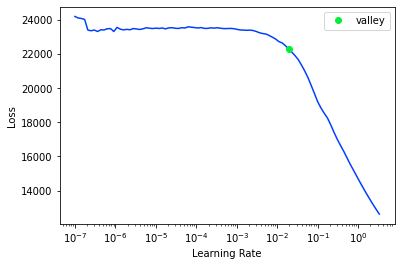

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  194.68     194.98
1  183.14     181.80
2   99.49      96.79
3  174.58     173.92
4  160.32     159.72
XGBoost RMSE:  0.94885945


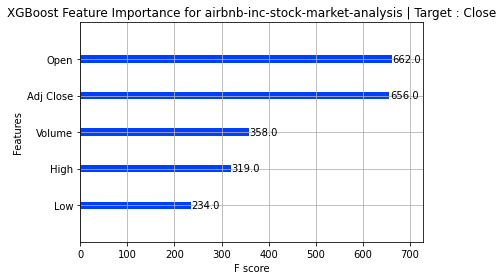

Target Variable: Low
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 454


 17%|█▋        | 7/42 [00:00<00:01, 32.15it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9893847524200693, 'Adjusted R-Squared': 0.9887528924450734, 'RMSE': 3.0207158137972874, 'Time taken': 0.0983574390411377}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9948124974728368, 'Adjusted R-Squared': 0.9945037175605057, 'RMSE': 2.1116598665931097, 'Time taken': 0.035063743591308594}
{'Model': 'BayesianRidge', 'R-Squared': 0.9962946875686638, 'Adjusted R-Squared': 0.9960741332572748, 'RMSE': 1.7846671184352996, 'Time taken': 0.011548042297363281}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9940049939300876, 'Adjusted R-Squared': 0.993648148330688, 'RMSE': 2.2700719317499116, 'Time taken': 0.010722160339355469}
{'Model': 'DummyRegressor', 'R-Squared': -0.014858895515278414, 'Adjusted R-Squared': -0.07526716310547354, 'RMSE': 29.535725, 'Time taken': 0.008672475814819336}
{'Model': 'ElasticNet', 'R-Squared': 0.9775494052267582, 'Adjusted R-Squared': 0.9762130602997795, 'RMSE': 4.392974990917797, 'Time taken': 0.009727716445922852}

 26%|██▌       | 11/42 [00:00<00:01, 24.19it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9968451411090411, 'Adjusted R-Squared': 0.9966573518893411, 'RMSE': 1.6467769323112438, 'Time taken': 0.15347981452941895}
{'Model': 'GammaRegressor', 'R-Squared': 0.9541562714238853, 'Adjusted R-Squared': 0.9514274780562594, 'RMSE': 6.277471816972053, 'Time taken': 0.012207746505737305}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -107.2781113348583, 'Adjusted R-Squared': -113.72323700955224, 'RMSE': 305.0809859536108, 'Time taken': 0.03251338005065918}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9944131335667873, 'Adjusted R-Squared': 0.9940805819933818, 'RMSE': 2.1914367966564225, 'Time taken': 0.14209818840026855}


 45%|████▌     | 19/42 [00:00<00:01, 20.84it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9898717811131894, 'Adjusted R-Squared': 0.9892689109413555, 'RMSE': 2.9506068383351995, 'Time taken': 0.19635224342346191}
{'Model': 'HuberRegressor', 'R-Squared': 0.9963282641068821, 'Adjusted R-Squared': 0.9961097083989584, 'RMSE': 1.7765626313275813, 'Time taken': 0.0235745906829834}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9903576936356985, 'Adjusted R-Squared': 0.9897837468282996, 'RMSE': 2.8789575, 'Time taken': 0.010995864868164062}
{'Model': 'KernelRidge', 'R-Squared': -25.087568999523217, 'Adjusted R-Squared': -26.640400487590075, 'RMSE': 149.74819996462696, 'Time taken': 0.018477201461791992}
{'Model': 'Lars', 'R-Squared': 0.7426366886165876, 'Adjusted R-Squared': 0.7273174438913845, 'RMSE': 14.873669369688974, 'Time taken': 0.020807504653930664}
{'Model': 'LarsCV', 'R-Squared': 0.995432522568504, 'Adjusted R-Squared': 0.9951606489118674, 'RMSE': 1.9814495098965645, 'Time taken': 0.03937649726867676}
{'Model': '

 52%|█████▏    | 22/42 [00:01<00:00, 21.73it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9960695246208542, 'Adjusted R-Squared': 0.9958355677530479, 'RMSE': 1.8380924255219304, 'Time taken': 0.08553528785705566}
{'Model': 'LassoLars', 'R-Squared': 0.4766446843581247, 'Adjusted R-Squared': 0.4454925822365845, 'RMSE': 21.210119975223673, 'Time taken': 0.010712385177612305}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9953817316590767, 'Adjusted R-Squared': 0.9951068347340217, 'RMSE': 1.9924360322967494, 'Time taken': 0.02015233039855957}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9946630869900239, 'Adjusted R-Squared': 0.994345413596573, 'RMSE': 2.1418540177605605, 'Time taken': 0.01262807846069336}
{'Model': 'LinearRegression', 'R-Squared': 0.9962864168011758, 'Adjusted R-Squared': 0.9960653701821982, 'RMSE': 1.7866578195339695, 'Time taken': 0.00989532470703125}
{'Model': 'LinearSVR', 'R-Squared': 0.9946389921064879, 'Adjusted R-Squared': 0.9943198844937788, 'RMSE': 2.1466835517071647, 'Time taken': 0.009964227676391602}


 71%|███████▏  | 30/42 [00:01<00:00, 14.35it/s]

{'Model': 'MLPRegressor', 'R-Squared': -11.635729756968498, 'Adjusted R-Squared': -12.387856528216624, 'RMSE': 104.21853639542277, 'Time taken': 0.6618578433990479}
{'Model': 'NuSVR', 'R-Squared': 0.8842720263107123, 'Adjusted R-Squared': 0.8773834564482548, 'RMSE': 9.973876350636353, 'Time taken': 0.03796744346618652}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9892636354142478, 'Adjusted R-Squared': 0.9886245660936673, 'RMSE': 3.0378996982640105, 'Time taken': 0.020091772079467773}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9962864168011757, 'Adjusted R-Squared': 0.9960653701821981, 'RMSE': 1.7866578195339808, 'Time taken': 0.031174898147583008}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9931704032410359, 'Adjusted R-Squared': 0.9927638796244309, 'RMSE': 2.42293819670536, 'Time taken': 0.0208895206451416}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9797162703073274, 'Adjusted R-Squared': 0.9785089054446684, 'RMSE': 4.175598303879054, 'Time taken': 

 79%|███████▊  | 33/42 [00:06<00:03,  2.39it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.041447926928273704, 'Adjusted R-Squared': -0.1034388749597186, 'RMSE': 29.92013751396458, 'Time taken': 4.1723313331604}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9962864168011758, 'Adjusted R-Squared': 0.9960653701821982, 'RMSE': 1.7866578195339682, 'Time taken': 0.024912357330322266}


 83%|████████▎ | 35/42 [00:06<00:02,  2.75it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9948097492186871, 'Adjusted R-Squared': 0.9945008057197995, 'RMSE': 2.112219153989168, 'Time taken': 0.277346134185791}
{'Model': 'Ridge', 'R-Squared': 0.9961760202410597, 'Adjusted R-Squared': 0.9959484023982657, 'RMSE': 1.8130200115189326, 'Time taken': 0.011150360107421875}
{'Model': 'RidgeCV', 'R-Squared': 0.9963059893839837, 'Adjusted R-Squared': 0.9960861077996971, 'RMSE': 1.7819432749676773, 'Time taken': 0.013005256652832031}
{'Model': 'SGDRegressor', 'R-Squared': 0.9954749716441451, 'Adjusted R-Squared': 0.9952056247182014, 'RMSE': 1.972220450623094, 'Time taken': 0.0167233943939209}
{'Model': 'SVR', 'R-Squared': 0.8885143344783271, 'Adjusted R-Squared': 0.8818782829591798, 'RMSE': 9.789360470567102, 'Time taken': 0.01979804039001465}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9962864168011758, 'Adjusted R-Squared': 0.9960653701821982, 'RMSE': 1.7866578195339695, 'Time taken': 0.01174616813659668}
{'Model': 'Tweedie

100%|██████████| 42/42 [00:06<00:00,  6.05it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9932241297614343, 'Adjusted R-Squared': 0.9928208041519958, 'RMSE': 2.4133892, 'Time taken': 0.4448068141937256}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9895465226570075, 'Adjusted R-Squared': 0.9889242918627817, 'RMSE': 2.997610466374882, 'Time taken': 0.05637025833129883}
Project: airbnb-inc-stock-market-analysis
airbnb-inc-stock-market-analysis
Target: Low
Low
Target Standard Deviation: 26.93364143371582
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          1.00       1.00   1.65   
HuberRegressor                               1.00       1.00   1.78   
RidgeCV                                      1.00       1.00   1.78   
BayesianRidge                                1.00       1.00   1.78   
LinearRegression                             1.00       1.00   1.79   
RANSACRegressor                              1.00

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,22092.632812,15572.178711,124.788536,00:00
1,20011.388672,10097.907227,100.488342,00:00
2,16745.978516,46156.523438,214.840683,00:00


Better model found at epoch 0 with _rmse value: 124.78853607177734.
Better model found at epoch 1 with _rmse value: 100.48834228515625.
No improvement since epoch 1: early stopping


,Open,High,Close,Adj Close,Volume,Low,Low_pred
0,0.02,0.20,0.32,0.32,-0.57,153.44,48.98
1,-0.20,-0.24,-0.19,-0.19,-0.93,144.02,29.25
2,0.77,0.63,0.70,0.70,-0.81,170.58,134.82
3,-1.50,-1.45,-1.44,-1.44,-0.50,111.53,86.97
4,-0.11,-0.11,-0.09,-0.09,-0.37,149.95,13.75
5,-0.05,-0.18,-0.18,-0.18,0.23,144.90,14.37
6,0.49,0.41,0.56,0.56,-0.49,161.96,95.55
7,-0.15,-0.12,-0.06,-0.06,1.25,148.84,32.19
8,1.67,1.56,1.70,1.70,-0.77,191.50,354.18


<Figure size 432x288 with 0 Axes>

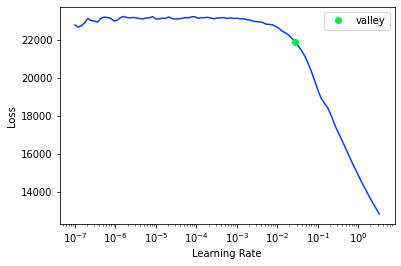

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  116.30     115.60
1  119.51     122.63
2  114.39     114.63
3  196.16     191.94
4  159.55     158.42
XGBoost RMSE:  2.4133892


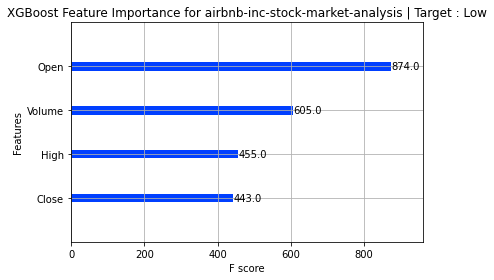

Target Variable: High
CATS=====================
[]
CONTS=====================
['Open', 'Low', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'Low', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 454


 17%|█▋        | 7/42 [00:00<00:01, 32.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9833719733337654, 'Adjusted R-Squared': 0.9823822098417276, 'RMSE': 3.8081400561617698, 'Time taken': 0.10098099708557129}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9905821033262626, 'Adjusted R-Squared': 0.9900215142385401, 'RMSE': 2.8659559902317553, 'Time taken': 0.03419208526611328}
{'Model': 'BayesianRidge', 'R-Squared': 0.9928266249856789, 'Adjusted R-Squared': 0.9923996383776835, 'RMSE': 2.501234004124545, 'Time taken': 0.01013946533203125}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9828371912346074, 'Adjusted R-Squared': 0.9818155954747626, 'RMSE': 3.868893171664417, 'Time taken': 0.010517358779907227}
{'Model': 'DummyRegressor', 'R-Squared': -0.0007890568960715605, 'Adjusted R-Squared': -0.06035983409226642, 'RMSE': 29.543627, 'Time taken': 0.008669614791870117}
{'Model': 'ElasticNet', 'R-Squared': 0.9760928576054582, 'Adjusted R-Squared': 0.9746698134153069, 'RMSE': 4.566215359023905, 'Time taken': 0.00935220718383789}
{

 24%|██▍       | 10/42 [00:00<00:01, 23.63it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9944596943725205, 'Adjusted R-Squared': 0.9941299142756467, 'RMSE': 2.19816059286743, 'Time taken': 0.1550755500793457}
{'Model': 'GammaRegressor', 'R-Squared': 0.9522449027911037, 'Adjusted R-Squared': 0.9494023374810504, 'RMSE': 6.4536056343466734, 'Time taken': 0.012705802917480469}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -208.53359073436266, 'Adjusted R-Squared': -221.00582827807472, 'RMSE': 427.4835271825321, 'Time taken': 0.046619415283203125}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9901017153416861, 'Adjusted R-Squared': 0.9895125317310722, 'RMSE': 2.9381402724558825, 'Time taken': 0.1380617618560791}


 43%|████▎     | 18/42 [00:00<00:01, 20.00it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9884426651037364, 'Adjusted R-Squared': 0.9877547285027682, 'RMSE': 3.174836798081529, 'Time taken': 0.19933342933654785}
{'Model': 'HuberRegressor', 'R-Squared': 0.9930842222828606, 'Adjusted R-Squared': 0.9926725688473166, 'RMSE': 2.4559135167812163, 'Time taken': 0.02551889419555664}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9893301281150741, 'Adjusted R-Squared': 0.9886950166933524, 'RMSE': 3.050508, 'Time taken': 0.010524749755859375}
{'Model': 'KernelRidge', 'R-Squared': -27.034991010293126, 'Adjusted R-Squared': -28.703740475191527, 'RMSE': 156.3661585458199, 'Time taken': 0.018023014068603516}
{'Model': 'Lars', 'R-Squared': 0.9928405700025152, 'Adjusted R-Squared': 0.9924144134550459, 'RMSE': 2.4988016261813946, 'Time taken': 0.020003318786621094}
{'Model': 'LarsCV', 'R-Squared': 0.9913995387023453, 'Adjusted R-Squared': 0.9908876064822468, 'RMSE': 2.7387565504929823, 'Time taken': 0.03847384452819824}
{'Model': 'L

 50%|█████     | 21/42 [00:01<00:01, 20.60it/s]

{'Model': 'LassoCV', 'R-Squared': 0.9920129565024455, 'Adjusted R-Squared': 0.9915375372466386, 'RMSE': 2.6392806953415495, 'Time taken': 0.08094024658203125}
{'Model': 'LassoLars', 'R-Squared': 0.557080538154235, 'Adjusted R-Squared': 0.5307162844729394, 'RMSE': 19.65418040749272, 'Time taken': 0.011368036270141602}
{'Model': 'LassoLarsCV', 'R-Squared': 0.991514858206692, 'Adjusted R-Squared': 0.9910097902428047, 'RMSE': 2.720333241242684, 'Time taken': 0.02160191535949707}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9928405700025152, 'Adjusted R-Squared': 0.9924144134550459, 'RMSE': 2.4988016261813946, 'Time taken': 0.011443614959716797}
{'Model': 'LinearRegression', 'R-Squared': 0.9928405700025155, 'Adjusted R-Squared': 0.9924144134550461, 'RMSE': 2.4988016261813675, 'Time taken': 0.009644269943237305}
{'Model': 'LinearSVR', 'R-Squared': 0.9903472942929671, 'Adjusted R-Squared': 0.9897727284770723, 'RMSE': 2.9014633502712592, 'Time taken': 0.010619878768920898}


 71%|███████▏  | 30/42 [00:01<00:00, 14.54it/s]

{'Model': 'MLPRegressor', 'R-Squared': -13.667491127818979, 'Adjusted R-Squared': -14.540556075903442, 'RMSE': 113.10204916430085, 'Time taken': 0.6664495468139648}
{'Model': 'NuSVR', 'R-Squared': 0.9115311130118398, 'Adjusted R-Squared': 0.9062651078339731, 'RMSE': 8.783909207035814, 'Time taken': 0.03866744041442871}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9803985817650342, 'Adjusted R-Squared': 0.9792318306796196, 'RMSE': 4.134626692355984, 'Time taken': 0.020758867263793945}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9928405700025154, 'Adjusted R-Squared': 0.992414413455046, 'RMSE': 2.498801626181371, 'Time taken': 0.03508925437927246}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9923548203369388, 'Adjusted R-Squared': 0.9918997501188994, 'RMSE': 2.5821793536449276, 'Time taken': 0.018681764602661133}
{'Model': 'PoissonRegressor', 'R-Squared': 0.9809473382574391, 'Adjusted R-Squared': 0.9798132512489534, 'RMSE': 4.07633985360328, 'Time taken': 0

 79%|███████▊  | 33/42 [00:05<00:02,  3.11it/s]

{'Model': 'QuantileRegressor', 'R-Squared': -0.010490464676532474, 'Adjusted R-Squared': -0.07063870662156413, 'RMSE': 29.686477332176505, 'Time taken': 3.1625399589538574}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9928405700025155, 'Adjusted R-Squared': 0.9924144134550461, 'RMSE': 2.4988016261813675, 'Time taken': 0.0314488410949707}


 83%|████████▎ | 35/42 [00:05<00:02,  3.45it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9914558482748913, 'Adjusted R-Squared': 0.9909472678150634, 'RMSE': 2.7297761329157435, 'Time taken': 0.2863171100616455}
{'Model': 'Ridge', 'R-Squared': 0.9923884634964409, 'Adjusted R-Squared': 0.9919353958474195, 'RMSE': 2.5764915569607583, 'Time taken': 0.014486312866210938}
{'Model': 'RidgeCV', 'R-Squared': 0.9927909631862972, 'Adjusted R-Squared': 0.9923618538521483, 'RMSE': 2.507443627849597, 'Time taken': 0.010901689529418945}
{'Model': 'SGDRegressor', 'R-Squared': 0.9916685743143401, 'Adjusted R-Squared': 0.991172656118765, 'RMSE': 2.6955799588600393, 'Time taken': 0.019214868545532227}
{'Model': 'SVR', 'R-Squared': 0.9162341593431719, 'Adjusted R-Squared': 0.911248097399313, 'RMSE': 8.547242622660999, 'Time taken': 0.021539926528930664}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9928405700025155, 'Adjusted R-Squared': 0.9924144134550461, 'RMSE': 2.4988016261813675, 'Time taken': 0.011195182800292969}
{'Model': 'Twe

100%|██████████| 42/42 [00:06<00:00,  6.32it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9903801347957032, 'Adjusted R-Squared': 0.9898075237716379, 'RMSE': 2.8965235, 'Time taken': 1.0723679065704346}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9879723546523356, 'Adjusted R-Squared': 0.9872564233816412, 'RMSE': 3.238790548872404, 'Time taken': 0.0727543830871582}
Project: airbnb-inc-stock-market-analysis
airbnb-inc-stock-market-analysis
Target: High
High
Target Standard Deviation: 28.959468841552734
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
ExtraTreesRegressor                          0.99       0.99   2.20   
HuberRegressor                               0.99       0.99   2.46   
LinearRegression                             0.99       0.99   2.50   
TransformedTargetRegressor                   0.99       0.99   2.50   
RANSACRegressor                              0.99       0.99   2.50   
OrthogonalMatchingPursuitCV                  0.

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,24754.814453,17766.683594,133.291718,00:00
1,22696.447266,6777.654785,82.326508,00:00
2,19108.507812,46439.390625,215.498016,00:00


Better model found at epoch 0 with _rmse value: 133.29171752929688.
Better model found at epoch 1 with _rmse value: 82.32650756835938.
No improvement since epoch 1: early stopping


,Open,Low,Close,Adj Close,Volume,High,High_pred
0,1.64,1.73,1.68,1.68,-0.45,209.22,253.63
1,0.68,0.83,0.81,0.81,-0.29,178.88,125.70
2,0.58,0.56,0.46,0.46,-0.75,170.12,115.42
3,0.95,1.00,0.85,0.85,-0.91,181.49,191.95
4,0.51,0.49,0.53,0.53,-0.64,168.72,103.43
5,0.87,0.82,0.78,0.78,-0.80,178.72,169.04
6,0.23,0.34,0.47,0.47,-0.25,166.88,49.84
7,-1.42,-1.33,-1.31,-1.31,-0.47,116.44,107.70
8,0.79,0.84,0.77,0.77,-0.70,176.32,155.41


<Figure size 432x288 with 0 Axes>

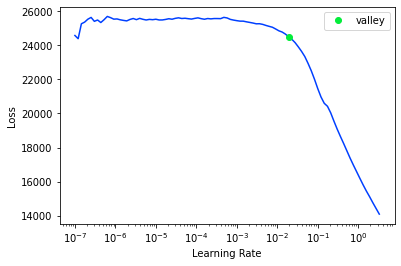

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  180.70     183.03
1  176.45     173.55
2  150.50     150.62
3  167.27     166.73
4   97.09      98.84
XGBoost RMSE:  2.8965712


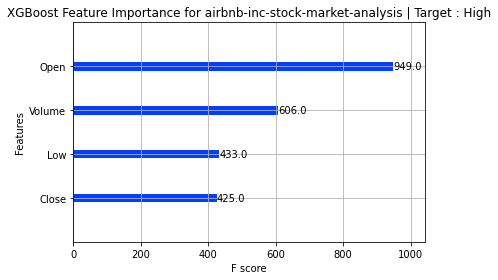

<Figure size 432x288 with 0 Axes>

In [22]:
target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors='coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].apply(pd.to_numeric, errors='coerce').dropna()

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].apply(pd.to_numeric, errors='coerce').dropna()
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

  feature  importance
0    Open      874.00
1    High      455.00
2   Close      443.00
3  Volume      605.00
0    Open      982.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

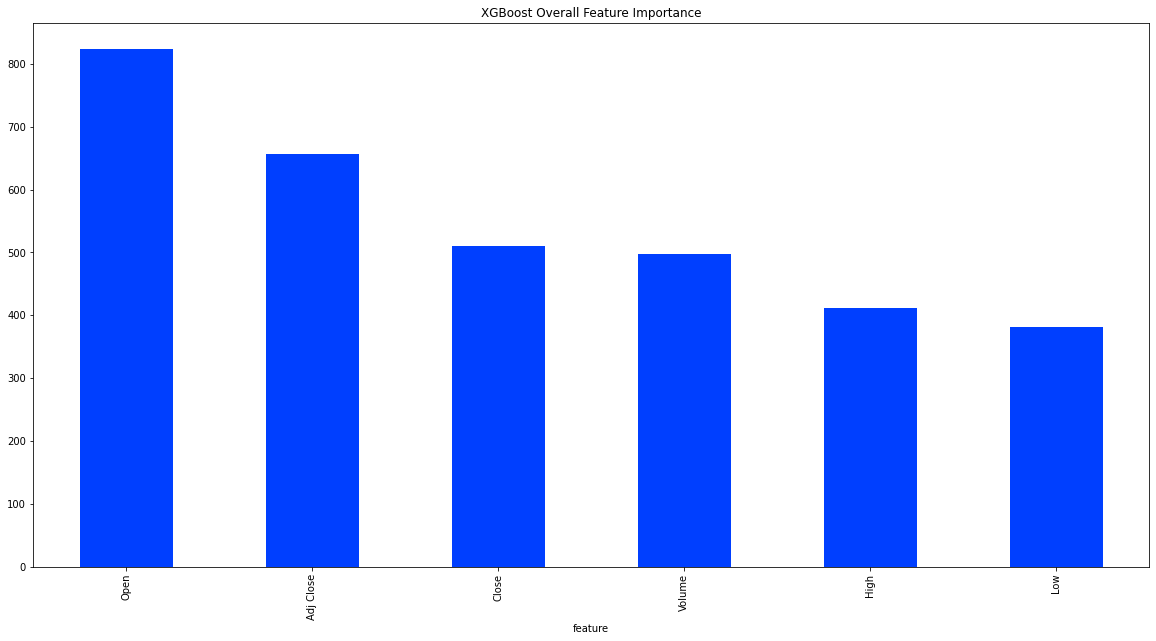

In [23]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [24]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **To Be Continued...**